# A Thorough Introduction to Boltzmann Machines

The principal task of machine learning is to fit a model to some data. Thinking on the level of APIs, a model is an object with two methods:

```python
class Model:
    
    def likelihood(self, x):
        pass
        
    def sample(self, n_samples):
        pass
```

## Likelihood

How likely is the query point(s) $x$ under our model? In other words, how likely was it that our model produced $x$? 

The likelihood gives a value proportional to a valid probability, but is not necessarily a valid probability itself.

(Finally, the likelihood is often used as an umbrella term for, or interchangeably with, the probability density. The mainstream machine learning community would do well to agree to the use of one of these terms, and to sunset the other; while their definitions may differ slightly, the confusion brought about by their shared used sharply outweighs the pedagogical purity maintained by keeping them distinct.

## Sample

Draw samples from the model.

## Denotation

Canonically, we denote an instance of our `Model` in mathematical syntax as follows:

$$
x \sim p(x)
$$

Again, this simple denotation implies two methods: that we can evaluate the likehood of having observed $x$ under our model $p$, and that we can sample a new value $x$ from our model $p$. 

Often, we work with *conditional* models, such as $y \sim p(y\vert x)$, in classification and regression tasks. The same two implicit methods apply.

## Boltzmann machines

A Boltzmann machine is one of the simplest mechanisms for modeling $p(x)$. It is an undirected graphical model where every dimension $x_i$ of a given observation $x$ influences every other dimension. For $x \in R^3$, our model would look as follows:

![](figures/boltzmann-machine.svg)

For $x \in R^n$, a given node $x_i$ would have $n - 1$ outgoing connections in total—one to each of the other nodes $x_j$ for $j \neq i$.

Finally, a Boltzmann machine strictly operates on *binary* data. This keeps things simple.

## Computing the likelihood

A Boltzmann machines admits the following formula for computing the likelihood of data points $x^{(1)}, ..., x^{(n)}$:

$$
H(x) = \sum\limits_{i \neq j} w_{i, j} x_i x_j + \sum\limits_i b_i x_i
$$

$$
p(x) = \frac{\exp{(H(x))}}{Z}
$$

$$
\mathcal{L}(x^{(1)}, ..., x^{(n)}) = \prod\limits_{i=1}^n p(x^{(i)})
$$

Note:

- Since our weights can be negative, $H(x)$ can be negative. As a likelihood gives an optionally-normalized probability, it must be non-negative.
- To enforce this constraint, we exponentiate $H(x)$ in the second equation.
- To normalize, we divide by the normalization constant $Z$, i.e. the sum of the likelihoods of all possible values of $x^{(1)}, ..., x^{(n)}$.

## Computing the partition function, with examples

In the case of 2-dimensional binary $x$, the only possible "configurations" of $x$ are: $[0, 0], [0, 1], [1, 0], [1, 1]$, i.e. 4 distinct values. This means that in evaluating the likelihood of one datum $x$, the normalization constant $Z$ would be a sum of 4 terms.

Now, with two data points $x^{(1)}$ and $x^{(2)}$, there are 16 possible "configurations":

1. $x^{(1)} = [0, 0]$, $x^{(2)} = [0, 0]$
2. $x^{(1)} = [0, 0]$, $x^{(2)} = [0, 1]$
3. $x^{(1)} = [0, 0]$, $x^{(2)} = [1, 0]$
4. $x^{(1)} = [0, 0]$, $x^{(2)} = [1, 1]$
5. $x^{(1)} = [0, 1]$, $x^{(2)} = [0, 0]$
6. $x^{(1)} = [0, 1]$, $x^{(2)} = [0, 1]$
7. Etc.

This means that in evaluating the likelihood of $\mathcal{L}(x^{(1)}, x^{(2)})$, the normalization constant $Z$ would be a sum of 16 terms.

More generally, given $d$-dimensional $x$, where each $x_i$ can assume one of $v$ distinct values, and $n$ data points $x^{(1)}, ..., x^{(n)}$—in evaluating the likelihood of $\mathcal{L}(x^{(1)}, ..., x^{(n)})$ the normalization constant $Z$ would be a sum of $(v^d)^n$ terms. **With a non-trivially large $v$ or $d$ (in the discrete case), or a non-trivially large $k$ in the continuous case, this becomes intractable to compute.**

In the case of a Boltzmann machine, $v = 2$, which is not large. Below, we will vary $d$ and examine its impact on the tractability (in terms of, "can we actually compute $Z$ before the end of the universe?") of inference.

## The likelihood function in code

In code, the likelihood function looks as follows:

```python
def _unnormalized_likelihood(self, x):
    return np.exp(self._H(x))
        
def _H(self, x):
    h = 0
    for i, j in self.var_combinations:
        h += self.weights[i, j] * x[i] * x[j]
    h += self.biases @ x
    return h

def likelihood(self, x, log=False):
    """
    Must have the dimensionality of the data observations. To marginalize, put ellipses (...)
    in the elements over which you wish to marginalize.
    """
    x = np.array(x)
    if not self.n_units in x.shape and len(x.shape) in (1, 2):
        raise('Please pass 1 or more points of `n_units` dimensions')

    # compute unnormalized likelihoods
    multiple_samples = len(x.shape) == 2
    if multiple_samples:
        likelihood = [self._unnormalized_likelihood(point) for point in x]
    else:
        likelihood = [self._unnormalized_likelihood(x)]

    # compute partition function
    Z = sum([self._unnormalized_likelihood(config) for config in self.all_configs])

    if log:
        return sum([np.log(lik) - np.log(Z) for lik in likelihood])
    else:
        return reduce(np.multiply, [lik / Z for lik in likelihood])
```

This code block is longer than you might expect because it includes a few supplementary behaviors, namely:

- Computing the likelihood of one or more points
- Avoiding redundant computation of `Z`
- Optionally computing the log-likelihood

Above all, note that: the likelihood is a function of the model's parameters, i.e. `self.weights` and `self.biases`, which we can vary, and the data `x`, which we can't.

## Training the model

At the outset, the parameters `self.weights` and `self.biases` of our model are initialized at random. Trivially, such that the values returned by `likelihood` and `sample` are useful, we must first update these parameters by fitting this model to observed data.

To do so, we will employ the principal of maximum likelihood: compute the parameters that make the observed data maximally likely under the model, via gradient ascent.

## Gradients

Since our model is simple, we can derive exact gradients by hand. We will work with the log-likelihood instead of the true likelihood to avoid issues of computational underflow. Below, we simplify this expression, then compute its various gradients.

### $\log{\mathcal{L}}$

$$
\mathcal{L}(x^{(1)}, ..., x^{(n)}) = \prod\limits_{k=1}^n \frac{\exp{(H(x^{(k)})}}{Z}
$$

$$
\begin{align*}
\log{\mathcal{L}(x^{(1)}, ..., x^{(n)})} 
&= \sum\limits_{k=1}^n \log{\frac{\exp{(H(x^{(k)})}}{Z}}\\
&= \sum\limits_{k=1}^n \log{\big(\exp{(H(x^{(k)})}\big)} - \log{Z}\\
&= \sum\limits_{k=1}^n H(x^{(k)}) - \log{Z}
\end{align*}
$$

This gives the total likelihood. Our aim is to maximize the expected likelihood with respect to the data generating distribution.

### Expected likelihood

$$
\begin{align*}
\mathop{\mathbb{E}}_{x \sim p_{\text{data}}}\big[ \mathcal{L}(x) \big]
&= \sum\limits_{k=1}^N p_{\text{data}}(x = x^{(k)}) \mathcal{L(x^{(k)})}\\
&= \sum\limits_{k=1}^N \frac{1}{N} \mathcal{L(x^{(k)})}\\
&= \frac{1}{N} \sum\limits_{k=1}^N  \mathcal{L(x^{(k)})}\\
\end{align*}
$$

In other words, the average. We will continue to denote this as $\mathcal{L}$, i.e. $\mathcal{L} = \frac{1}{N} \sum\limits_{k=1}^n H(x^{(k)}) - \log{Z}$.

Now, deriving the gradient with respect to our weights:

### $\nabla_{w_{i, j}}\log{\mathcal{L}}$

$$
\begin{align*}
\nabla_{w_{i, j}} \frac{1}{N} \sum\limits_{k=1}^n H(x^{(k)}) - \log{Z}
&= \frac{1}{N} \sum\limits_{k=1}^n \nabla_{w_{i, j}}  H(x^{(k)}) - \frac{1}{N} \sum\limits_{k=1}^n \nabla_{w_{i, j}} \log{Z}
\end{align*}
$$

### First term

$$
\begin{align*}
\frac{1}{N} \sum\limits_{k=1}^n \nabla_{w_{i, j}}  H(x^{(k)})
&= \frac{1}{N} \sum\limits_{k=1}^n \nabla_{w_{i, j}} \sum\limits_{i \neq j} w_{i, j} x_i^{(k)} x_j^{(k)} + \sum\limits_i b_i x_i^{(k)}\\
&= \frac{1}{N} \sum\limits_{k=1}^n x_i^{(k)} x_j^{(k)}\\
&= \mathop{\mathbb{E}}_{x \sim p_{\text{data}}} [x_i  x_j]
\end{align*}
$$

### Second term

NB: $\sum\limits_{\mathcal{x}}$ implies a summation over all $(v^d)^n$ possible configurations of values that $x^{(1)}, ..., x^{(n)}$ can assume.

$$
\begin{align*}
\nabla_{w_{i, j}} \log{Z}
&= \nabla_{w_{i, j}} \log{\sum\limits_{\mathcal{x}}} \exp{(H(x))}\\
&= \frac{1}{\sum\limits_{\mathcal{x}} \exp{(H(x))}} \nabla_{w_{i, j}} \sum\limits_{\mathcal{x}} \exp{(H(x))}\\
&= \frac{1}{Z} \nabla_{w_{i, j}} \sum\limits_{\mathcal{x}} \exp{(H(x))}\\
&= \frac{1}{Z} \sum\limits_{\mathcal{x}} \exp{(H(x))} \nabla_{w_{i, j}} H(x)\\
&= \sum\limits_{\mathcal{x}} \frac{\exp{(H(x))}}{Z} \nabla_{w_{i, j}} H(x)\\
&= \sum\limits_{\mathcal{x}} P(x) \nabla_{w_{i, j}} H(x)\\
&= \sum\limits_{\mathcal{x}} P(x) [x_i  x_j]\\
&= \mathop{\mathbb{E}}_{x \sim p_{\text{model}}} [x_i  x_j]
\end{align*}
$$

### Putting it back together

Combining these constituent parts, we arrive at the following formula:

$$
\nabla_{w_{i, j}}\log{\mathcal{L}} = \mathop{\mathbb{E}}_{x \sim p_{\text{data}}} [x_i  x_j] - \mathop{\mathbb{E}}_{x \sim p_{\text{model}}} [x_i  x_j]
$$

Finally, following the same logic, we derive the exact gradient with respect to our biases:

$$
\nabla_{b_i}\log{\mathcal{L}} = \mathop{\mathbb{E}}_{x \sim p_{\text{data}}} [x_i] - \mathop{\mathbb{E}}_{x \sim p_{\text{model}}} [x_i]
$$

The first and second terms of each gradient are called, respectively, **the positive and negative phases.**

## Computing the positive phase

In the following toy example, our data are small: we can compute the positive phase using all of the training data, i.e. $\frac{1}{N} \sum\limits_{k=1}^n x_i^{(k)} x_j^{(k)}$. Were our data bigger, we could approximate this expectation with a mini-batch of training data and we do in SGD.

## Computing the negative phase

Again, this term asks us to compute then sum the log-likelihood over every possible data configuration in the support of our model, which is $O(nv^d)$. **With non-trivially large $v$ or $d$, this becomes intractable to compute.**

Below, we'll begin our toy example computing the true negative-phase, $\mathop{\mathbb{E}}_{x \sim p_{\text{model}}} [x_i  x_j]$, with varying data-dimensionalities $d$. Then, once this computation becomes slow, we'll look to approximate this expectation later on.

## Parameter updates in code

```python
def update_parameters_with_true_negative_phase(weights, biases, var_combinations, all_configs, data, alpha=alpha):
    model = Model(weights, biases, var_combinations, all_configs)
    model_distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = sum([config[i] * config[j] * likelihood for config, likelihood in model_distribution])

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = sum([config[i] * likelihood for config, likelihood in model_distribution])
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)
```

## Train model, visualize model distribution

Finally, we're ready to train. Using the true negative phase, let's train our model for 100 epochs with $d=3$ then visualize results.

In [1]:
from collections import defaultdict
from functools import reduce
from itertools import product, combinations
from time import time

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [16]:
seed = 42
alpha = .01


def reset_data_and_parameters(n_units=3, n_obs=100, p=[.8, .1, .5]):
    """
    Generate training data, weights, biases, and a list of all data configurations
    in our model's support.
    
    In addition, generate a list of tuples of the indices of adjacent nodes, which
    we'll use to update parameters without duplication. 
    
    For example, with `n_units=3`, we generate a matrix of weights with shape (3, 3); 
    however, there are only 3 distinct weights in this matrix that we'll actually 
    want to update: those connecting Node 0 --> Node 1, Node 1 --> Node 2, and 
    Node 0 --> Node 2. This function returns a list containing these tuples 
    named `var_combinations.
    
    :param n_units: the dimensionality of our data `d`
    :param n_obs: the number of observations in our training set
    :param p: a vector of the probabilities of observing a 1 in each index
        of the training data. The length of this vector must equal `n_units`
        
    :return: weights, biases, var_combinations, all_configs, data
    """
    np.random.seed(seed)
    
    # initialize data
    data = np.random.binomial(n=1, p=p, size=(100, n_units))
    
    # initialize parameters
    biases = np.random.randn(n_units)
    weights = np.random.randn(n_units, n_units)
    
    # a few other pieces we'll need
    var_combinations = list(combinations(range(n_units), 2))
    all_configs = list(product([0, 1], repeat=n_units))
    
    return weights, biases, var_combinations, all_configs, data


class Model:
    
    def __init__(self, weights, biases, var_combinations, all_configs):
        self.weights = weights
        self.biases = biases
        self.var_combinations = var_combinations
        self.all_configs = all_configs
        self.n_units = len(self.biases)
        
    @staticmethod
    def _inv_logit(z):
        return 1 / (1 + np.exp(-z))
        
    def _unnormalized_likelihood(self, x):
        return np.exp(self._H(x))
        
    def _H(self, x):
        h = 0
        for i, j in self.var_combinations:
            h += self.weights[i, j] * x[i] * x[j]
        h += self.biases @ x
        return h
    
    def likelihood(self, x, log=False):
        """
        :param x: a vector of shape (n_units,) or (n, n_units),
            where the latter is a matrix of multiple data points
            for which to compute the joint likelihood.
        """
        x = np.array(x)
        if not self.n_units in x.shape and len(x.shape) in (1, 2):
            raise('Please pass 1 or more points of `n_units` dimensions')
           
        # compute unnormalized likelihoods
        multiple_samples = len(x.shape) == 2
        if multiple_samples:
            likelihood = [self._unnormalized_likelihood(point) for point in x]
        else:
            likelihood = [self._unnormalized_likelihood(x)]
        
        # compute partition function
        Z = sum([self._unnormalized_likelihood(config) for config in self.all_configs])
        
        if log:
            return sum([np.log(lik) - np.log(Z) for lik in likelihood])
        else:
            return reduce(np.multiply, [lik / Z for lik in likelihood])
        
    def sample(self, n_samples=100, init_sample=None, burn_in=25, every_n=10, seed=seed) -> np.array:

        np.random.seed(seed)

        if burn_in > n_samples:
            raise("Can't burn in for more samples than there are in the chain")

        init_sample = init_sample or [0 for _ in self.biases]
        samples = [init_sample]

        def _gibbs_step(sample, i):
            z = sum([self.weights[i, j] * sample[j] for j in range(len(sample)) if j != i]) + self.biases[i]
            p = self._inv_logit(z)
            return np.random.binomial(n=1, p=p)

        for _ in range(n_samples):
            sample = list(samples[-1])  # make copy
            for i, _ in enumerate(sample):
                sample[i] = _gibbs_step(sample=sample, i=i)
            samples.append( sample )

        return np.array([sample for i, sample in enumerate(samples[burn_in:]) if i % every_n == 0])
    
    def conditional_likelihood(x, cond: dict):
        joint = np.array(x)
        for index, val in cond.items():
            if isinstance(joint[index], int):
                raise
            joint[index] = val

        evidence = [cond.get(i, ...) for i in range(len(x))]

        return self._unnormalized_likelihood(joint) / self.marginal_likelihood(evidence)
    
    def marginal_likelihood(self, x):
        """
        To marginalize, put ellipses (...) in the elements over 
        which you wish to marginalize.
        """
        unnormalized_lik = 0
        for config in product(*[[0, 1] if el == ... else [el] for el in x]):
            config = np.array(config)
            unnormalized_lik += np.exp(self._H(config))
        return unnormalized_lik


def update_parameters_with_true_negative_phase(weights, biases, var_combinations, all_configs, data, alpha=alpha, **kwargs):
    model = Model(weights, biases, var_combinations, all_configs)
    model_distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = sum([config[i] * config[j] * likelihood for config, likelihood in model_distribution])

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = sum([config[i] * likelihood for config, likelihood in model_distribution])
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)

In [17]:
weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=3)


for i in range(100):
    weights, biases = update_parameters_with_true_negative_phase(weights, biases, var_combinations, all_configs, data, alpha=1)
    
    lik = Model(weights, biases, var_combinations, all_configs).likelihood(data, log=True)
    if i % 10 == 0:
        print(f'Epoch: {i:2} | Likelihood: {lik}')

Epoch:  0 | Likelihood: -209.63758306786653
Epoch: 10 | Likelihood: -162.04280784271083
Epoch: 20 | Likelihood: -160.49961381649555
Epoch: 30 | Likelihood: -159.79539070373576
Epoch: 40 | Likelihood: -159.2853717231018
Epoch: 50 | Likelihood: -158.90186293631422
Epoch: 60 | Likelihood: -158.6084020645482
Epoch: 70 | Likelihood: -158.38094343579155
Epoch: 80 | Likelihood: -158.20287017780586
Epoch: 90 | Likelihood: -158.06232196551673


# Visualize samples

In [72]:
def plot_n_samples(n_samples, weights, biases):
    """
    TODO: put some axes on this thing and maybe label corners.
    """
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    samples = Model(weights, biases, var_combinations, all_configs).sample(n_samples)
    x, y, z = zip(*np.array(samples))
    
    x += np.random.randn(len(x)) * .05
    y += np.random.randn(len(y)) * .05
    z += np.random.randn(len(z)) * .05
    
    ax.scatter(x, y, z)
    ax.set_xlabel('Node 0')
    ax.set_ylabel('Node 1')
    ax.set_zlabel('Node 2')

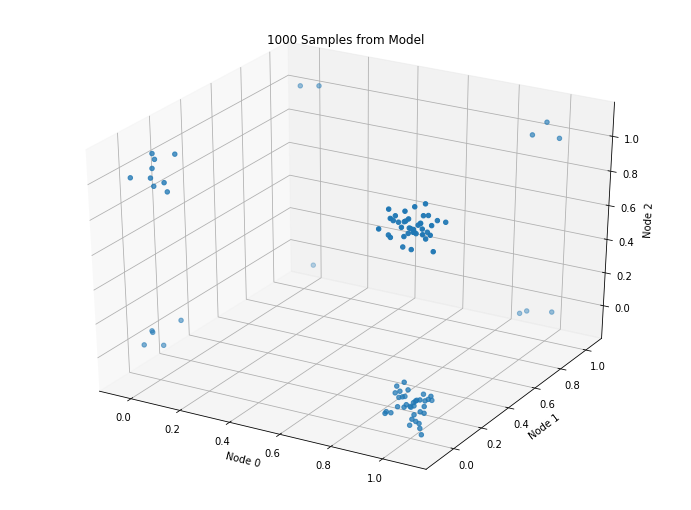

In [73]:
n_samples = 1000

plot_n_samples(n_samples, weights, biases)
_ = plt.title(f'{n_samples} Samples from Model')

The plot roughly matches the data-generating distribution: most points assume values of either $[1, 0, 1]$, or $[1, 0, 0]$ (given $p=[.8, .1, .5]$).

# Sampling, via Gibbs

The second, final method we need to implement is `sample`. In a Boltzmann machine, we typically do this via [Gibbs sampling](http://www.mit.edu/~ilkery/papers/GibbsSampling.pdf).

To effectuate this sampling scheme, we'll need a model of each data dimension conditional on the other data dimensions. For example, for $d=3$, we'll need to define:

- $p(x_0\vert x_1, x_2)$
- $p(x_1\vert x_0, x_2)$
- $p(x_2\vert x_0, x_1)$

Given that each dimension must assume a 0 or a 1, the above 3 models must necessarily return the probability of observing a 1 (where 1 minus this value gives the probability of observing a 0).

Let's derive these formulas using the workhorse axiom of conditional probability, starting with the first model:

$$
\begin{align*}
p(x_0 = 1\vert x_1, x_2)
&= \frac{p(x_0 = 1, x_1, x_2)}{p(x_1, x_2)}\\
&= \frac{p(x_0 = 1, x_1, x_2)}{\sum\limits_{x_0 \in [0, 1]} p(x_0, x_1, x_2)}\\
&= \frac{p(x_0 = 1, x_1, x_2)}{p(x_0 = 0, x_1, x_2) + p(x_0 = 1, x_1, x_2)}\\
&= \frac{1}{1 + \frac{p(x_0 = 0, x_1, x_2)}{p(x_0 = 1, x_1, x_2)}}\\
&= \frac{1}{1 + \frac{\exp{(H(x_0 = 0, x_1, x_2)))}}{\exp{(H(x_0 = 1, x_1, x_2)))}}}\\
&= \frac{1}{1 + \exp{(H(x_0 = 0, x_1, x_2) - H(x_0 = 1, x_1, x_2))}}\\
&= \frac{1}{1 + \exp{(\sum\limits_{i \neq j} w_{i, j} x_i x_j + \sum\limits_i b_i x_i - (\sum\limits_{i \neq j} w_{i, j} x_i x_j + \sum\limits_i b_i x_i))}}\\
&= \frac{1}{1 + \exp{(-\sum\limits_{j \neq i = 0} w_{i, j} x_j - b_i)}}\\
&= \sigma\bigg(\sum\limits_{j \neq i = 0} w_{i, j} x_j + b_i\bigg)\\
\end{align*}
$$

Pleasantly enough, this model resolves to a simple Binomial GLM, i.e. logistic regression, involving only its neighboring units and the weights that connect them.

With the requisite conditionals in hand, let's run this chain and compare it with our (trained) model's true probability distribution.

In [74]:
model = Model(weights, biases, var_combinations, all_configs)

distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]
assert sum([likelihood for config, likelihood in distribution]) == 1

for config, likelihood in distribution:
    print(f'{list(config)}: {likelihood:.4}')

[0, 0, 0]: 0.07327
[0, 0, 1]: 0.09227
[0, 1, 0]: 0.01366
[0, 1, 1]: 0.01938
[1, 0, 0]: 0.3351
[1, 0, 1]: 0.3622
[1, 1, 0]: 0.04693
[1, 1, 1]: 0.05715


Next, let's run a Gibbs chain for 1000 steps, compute the empirical probability distribution of the samples returned, and compare it to the true probability distribution.

In [75]:
empirical_dist = defaultdict(int)
samples = model.sample(n_samples=1000)
n_samples = len(samples)

for sample in samples:
    empirical_dist[tuple(sample)] += 1 / n_samples
assert np.round(sum(empirical_dist.values()), 8) == 1
    
for config, likelihood in distribution:
    empirical_probability = empirical_dist[tuple(config)]
    print(f'{list(config)}: {likelihood:.4} (true), {empirical_probability:.4} (empirical)')

[0, 0, 0]: 0.07327 (true), 0.05102 (empirical)
[0, 0, 1]: 0.09227 (true), 0.09184 (empirical)
[0, 1, 0]: 0.01366 (true), 0.0102 (empirical)
[0, 1, 1]: 0.01938 (true), 0.02041 (empirical)
[1, 0, 0]: 0.3351 (true), 0.3673 (empirical)
[1, 0, 1]: 0.3622 (true), 0.398 (empirical)
[1, 1, 0]: 0.04693 (true), 0.03061 (empirical)
[1, 1, 1]: 0.05715 (true), 0.03061 (empirical)


Close, ish enough.

# Scaling up, and hitting the bottleneck

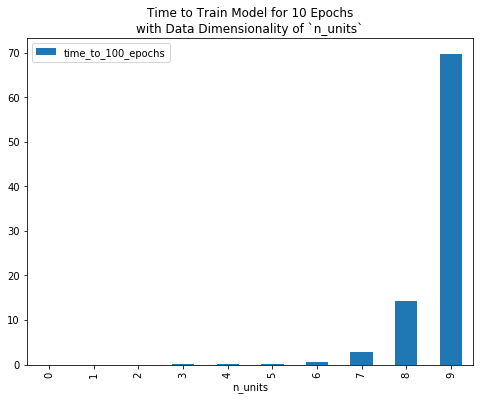

In [90]:
results = []

for n_units in range(10):
    p = np.random.uniform(size=n_units)
    weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=n_units, p=p)
    start = time()
    for i in range(10):
        weights, biases = update_parameters_with_true_negative_phase(weights, biases, var_combinations, all_configs, data, alpha=1)
    elapsed = time() - start
    
    results.append( {'n_units': n_units, 'time_to_10_epochs': elapsed})
    
    
results_df = pd.DataFrame(results)
title='Time to Train Model for 10 Epochs\nwith Data Dimensionality of `n_units`'
results_df.plot(x='n_units', kind='bar', figsize=(8, 6), title=title)

To reduce computational burden, and/or to fit a Boltzmann machine to data of non-trivial dimensionality (e.g. a 28x28 grey-scale image, which implies a Bernoulli random variable with 28x28=784 dimensions), we need to compute the positive and/or negative phase of our gradient faster than we currently are.

To compute the former more quickly, we could employ mini-batches as in canonical stochastic gradient descent.

In this post, we'll instead focus on ways to speed up the latter. Revisiting its expression, $\mathop{\mathbb{E}}_{x \sim p_{\text{model}}} [x_i  x_j]$, we readily see that we can create an unbiased estimator for this value by drawing Monte Carlo samples from our model, i.e.

$$
\mathop{\mathbb{E}}_{x \sim p_{\text{model}}} [x_i  x_j] \approx \frac{1}{N}\sum\limits_{k=1}^N x^{(k)}_i  x^{(k)}_j\quad\text{where}\quad x^{(k)} \sim p_{\text{model}}
$$

So, now we just need a way to draw these samples. Luckily, we have a Gibb's sampler to tap! 

**Instead of computing the true negative phase, i.e. summing $x_i  x_j$ over all permissible configurations $X$ under our model, we can approximate it by evaluating this expression for a few model samples, then taking the mean.**

We define this update mechanism here:

In [26]:
def update_parameters_with_gibbs_sampling(weights, biases, var_combinations, all_configs, data,
                                          seed=42, n_samples=1000, alpha=alpha, **kwargs):
    model_samples = Model(weights, biases, var_combinations, all_configs).sample(n_samples=n_samples, seed=seed)

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = (model_samples[:, i] * model_samples[:, j]).mean()

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = model_samples[:, i].mean()
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)

Next, we'll define a function that we can parameterize by an optimization algorithm (computing the true negative phase, or approximating it via Gibb's sampling, in the above case) which will train a model for $n$ epochs and return data requisite for plotting.

In [21]:
def train_model_for_n_epochs(optim_algo, n_units, p, run_num, epochs=100, alpha=alpha, verbose=True, n_samples=1000):
    weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=n_units, p=p)

    timestamps, updates = [], []
    for i in range(epochs):
        timestamps.append(time())
        
        weights, biases = optim_algo(
            weights=weights, 
            biases=biases, 
            var_combinations=var_combinations, 
            all_configs=all_configs, 
            data=data, 
            alpha=alpha,
            seed=run_num,
            n_samples=n_samples
        )
        
        elapsed = timestamps[-1] - timestamps[0]

        lik = Model(weights, biases, var_combinations, all_configs).likelihood(data, log=True)
        algo_name = optim_algo.__name__.split('update_parameters_with_')[-1]
        if i % 10 == 0 and verbose:
            print(f'Epoch: {i} | Likelihood: {lik}')

        updates.append( {'likelihood': lik, 'algo': algo_name, 'step': i, 'time': elapsed, 'run_num': run_num})
        
    return pd.DataFrame(updates)

# How does training progress for varying data dimensionalities?

Finally, for data of `n_units` 3, 4, 5, etc., let's train models for 100 epochs and plot curves. 

When training with the approximate negative phase, we'll train several models for a given `n_units`; Seaborn will then average results for us then plot a single line (I think). 

In [220]:
all_updates = []
alpha = .1
min_units, max_units = 3, 7

for n_units in range(min_units, max_units):
    
    np.random.seed(n_units)
    p = np.random.uniform(size=n_units)
    n_epochs = 100
    
    if n_units % 5 == 0:
        alpha /= 10

    for run in range(5):
        updates = train_model_for_n_epochs(
            update_parameters_with_gibbs_sampling, 
            n_units=n_units, 
            epochs=100,
            verbose=False, 
            alpha=alpha,
            run_num=run+1,
            p=p
        )
        all_updates.append(updates.assign(n_units=n_units))


    for run in range(1):
        updates = train_model_for_n_epochs(
            update_parameters_with_true_negative_phase, 
            n_units=n_units, 
            epochs=100,
            verbose=False, 
            alpha=alpha,
            run_num=run+1,
            p=p
        )
        all_updates.append(updates.assign(n_units=n_units))

# Plot

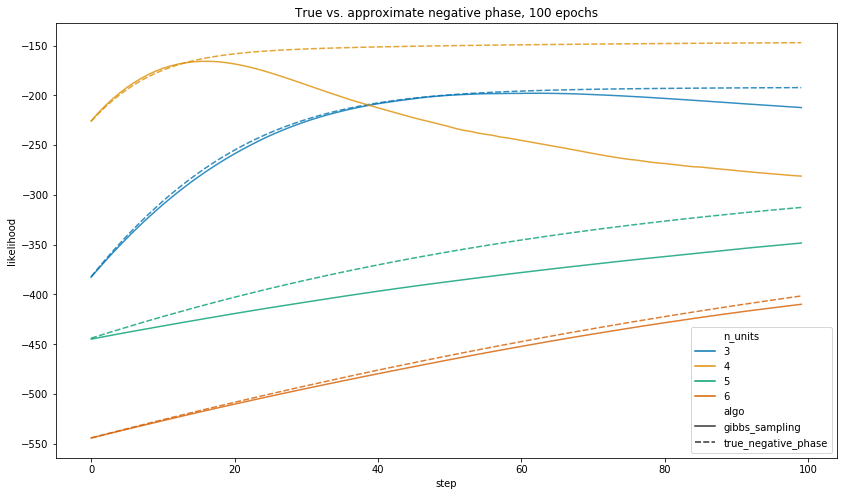

In [219]:
df = pd.concat(all_updates)

plt.figure(figsize=(14, 8))
plt.title('True vs. approximate negative phase, 100 epochs')
sns.lineplot(x="step", y="likelihood", hue="n_units", style="algo", 
                legend="full", data=df, ci=None, alpha=.8, palette=sns.color_palette("colorblind", max_units - min_units))

**When we let each algorithm run for 100 epochs, the true negative phase typically gives a model which assigns higher likelihood to the observed data.**

However, the central point is that 100 epochs of the true negative phase takes a lot longer to run than does 100 epochs for the approximate negative phase.

As such, let's run each for an equal amount of time, and plot results. Below, we define a function to train models for $n$ seconds (or 1 epoch—whichever comes first).

In [231]:
def train_model_for_n_seconds(optim_algo, n_units, p, run_num, n_seconds=10, alpha=alpha, verbose=True, n_samples=1000):
    weights, biases, var_combinations, all_configs, data = reset_data_and_parameters(n_units=n_units, p=p)

    elapsed = 0
    step = 0
    timestamps, updates = [], []
    
    while elapsed < n_seconds:
        timestamps.append(time())
        
        weights, biases = optim_algo(
            weights=weights, 
            biases=biases, 
            var_combinations=var_combinations, 
            all_configs=all_configs, 
            data=data, 
            alpha=alpha,
            seed=run_num,
            n_samples=n_samples
        )
        
        elapsed = timestamps[-1] - timestamps[0]
        
        lik = Model(weights, biases, var_combinations, all_configs).likelihood(data, log=True)
        algo_name = optim_algo.__name__.split('update_parameters_with_')[-1]
        if len(timestamps) > 1 and int(timestamps[-1]) - int(timestamps[-2]) > 0 and verbose:
            print(f'Elapsed: {elapsed:.2}s | Likelihood: {lik}')

        updates.append( {'likelihood': lik, 'algo': algo_name, 'step': step, 'time': elapsed, 'run_num': run_num})
        
        step += 1
        
    return pd.DataFrame(updates)

In [227]:
all_updates = []
n_seconds = 1
alpha = .1
min_units, max_units = 3, 10

for n_units in range(min_units, max_units):
    
    np.random.seed(n_units)
    p = np.random.uniform(size=n_units)
    n_epochs = 100
    
    if n_units % 5 == 0:
        alpha /= 10

    for run in range(5):
        updates = train_model_for_n_seconds(
            update_parameters_with_gibbs_sampling, 
            n_units=n_units, 
            n_seconds=n_seconds,
            verbose=False, 
            alpha=alpha,
            run_num=run+1,
            p=p
        )
        all_updates.append(updates.assign(n_units=n_units))


    for run in range(1):
        updates = train_model_for_n_seconds(
            update_parameters_with_true_negative_phase, 
            n_units=n_units, 
            n_seconds=n_seconds,
            verbose=False, 
            alpha=alpha,
            run_num=run+1,
            p=p
        )
        all_updates.append(updates.assign(n_units=n_units))

# How many epochs do we actually get through?

First, let's examine how many epochs each algorithm completes in its allotted time. In fact, for some values of `n_units`, we couldn't even complete a single epoch (when computing the true negative phase) in <= 1 second.

Text(0,0.5,'Log # of epochs')

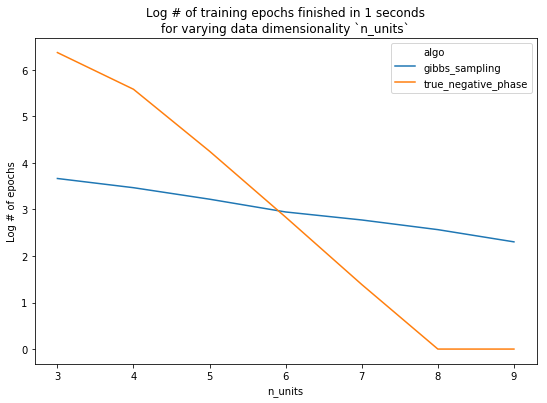

In [232]:
n_steps_df = df.groupby(['algo', 'n_units'])['step'].max().map(np.log).reset_index()

plt.figure(figsize=(9, 6))
plt.title('Log # of training epochs finished in 1 seconds\nfor varying data dimensionality `n_units`')
sns.lineplot(x='n_units', y='step', hue='algo', data=n_steps_df)
plt.ylabel('Log # of epochs')

Finally, we look at performance. With `n_units <= 7`, we see that 1 second of training with the true negative phase yields a better model. Conversely, **using 7 or more units, the added performance given by using the true negative phase is overshadowed by the amount of time it takes the model to train.**

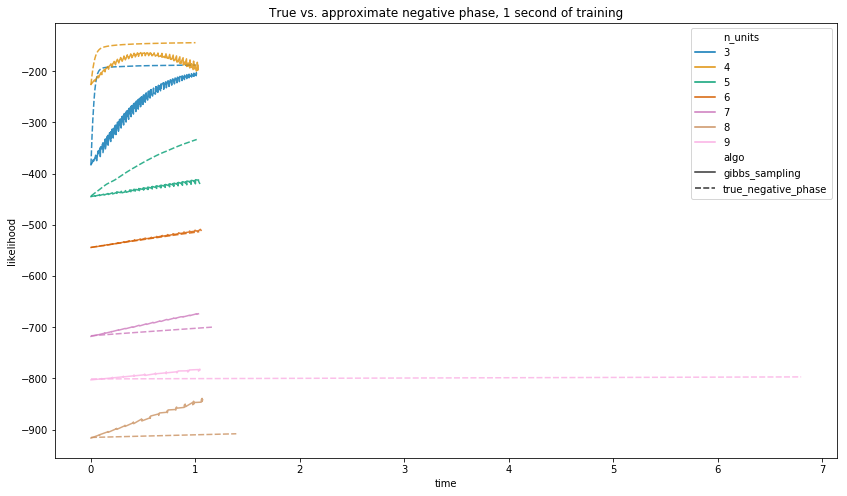

In [233]:
df = pd.concat(all_updates)

plt.figure(figsize=(14, 8))
plt.title('True vs. approximate negative phase, 1 second of training')
sns.lineplot(x="time", y="likelihood", hue="n_units", style="algo", 
             legend="full", data=df, ci=None, alpha=.8, 
             palette=sns.color_palette("colorblind", max_units - min_units))

# Summary

Throughout this post, we've given a thorough introduction to a Boltzmann machine: what it does, how it trains, and some of the computational burdens and considerations inherent.

In the next post, we'll look at cheaper, more inventive algorithms for avoiding the computating of the negative phase, and describe how they're used in common machine learning models and training routines.